In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

def compute_gradient_U(x, mu1=0.0, sigma1=1.0):
    return (x - mu1) / (sigma1**2)

def compute_gradient_V(y, mu2=2.0, sigma2=0.5):
    return (y - mu2) / (sigma2**2)

def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    rng = np.random.default_rng(seed)
    cov = np.array([[sigma1**2, rho * sigma1 * sigma2],
                    [rho * sigma1 * sigma2, sigma2**2]])
    mean = np.array([mu1, mu2])
    samples = rng.multivariate_normal(mean, cov, size=n)
    return samples[:, 0], samples[:, 1]

# Fixed parameters
d = 1
T = 2
dt = 0.01
N = int(np.round(T / dt))
h_NW = 0.01
epsilon = 1e-6
seed = 42
mu1, sigma1 = 0, 1
mu2, sigma2 = 2, 0.5
rho = 0.6

# Twelve n_samples from 10 to 10,000 (log‐spaced)
n_list = np.unique(np.round(np.logspace(np.log10(10), np.log10(5000), 20))).astype(int)
# Storage
rel_errors_kNN = []
rel_errors_OLS = []
rel_errors_NW = []

time_kNN = []
time_OLS = []
time_NW = []

for n_samples in n_list:
    # 1) draw fresh samples of size n_samples
    X0, Y0 = sample_bivariate_normal(
        n=n_samples,
        mu1=mu1, sigma1=sigma1,
        mu2=mu2, sigma2=sigma2,
        rho=rho,
        seed=seed
    )
    W2_sq_emp = W2_empirical(X0, Y0)**2
    k_neighbors = int(np.round(n_samples**(2/(d+4))))

    # ---- k-NN timing & error ----
    t0 = time.perf_counter()
    err_kNN, X_kNN, Y_kNN, _, mY_kNN, mX_kNN = euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='knn',
        h=None,
        k=k_neighbors,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )
    t1 = time.perf_counter()
    time_kNN.append(t1 - t0)

    min_err_kNN = np.min(err_kNN)
    rel_err_kNN = (min_err_kNN - W2_sq_emp)**2 / (W2_sq_emp**2)
    rel_errors_kNN.append(rel_err_kNN)

    # ---- OLS timing & error ----
    t0 = time.perf_counter()
    err_OLS, X_OLS, Y_OLS, _, mY_OLS, mX_OLS = euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='ols',
        h=None,
        k=None,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )
    t1 = time.perf_counter()
    time_OLS.append(t1 - t0)

    min_err_OLS = np.min(err_OLS)
    rel_err_OLS = (min_err_OLS - W2_sq_emp)**2 / (W2_sq_emp**2)
    rel_errors_OLS.append(rel_err_OLS)

    # ---- Nadaraya-Watson timing & error ----
    t0 = time.perf_counter()
    err_NW, X_NW, Y_NW, _, mY_NW, mX_NW = euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='nadaraya',
        h=h_NW,
        k=None,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )
    t1 = time.perf_counter()
    time_NW.append(t1 - t0)

    min_err_NW = np.min(err_NW)
    rel_err_NW = (min_err_NW - W2_sq_emp)**2 / (W2_sq_emp**2)
    rel_errors_NW.append(rel_err_NW)

# Convert to numpy arrays
n_arr = np.array(n_list)
rel_errors_kNN = np.array(rel_errors_kNN)
rel_errors_OLS = np.array(rel_errors_OLS)
rel_errors_NW = np.array(rel_errors_NW)

time_kNN = np.array(time_kNN)
time_OLS = np.array(time_OLS)
time_NW = np.array(time_NW)

In [2]:
import ot
from scipy.stats import norm

# Function to draw correlated Gaussian samples
def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    rng = np.random.default_rng(seed)
    cov = np.array([[sigma1**2,        rho * sigma1 * sigma2],
                    [rho * sigma1 * sigma2, sigma2**2       ]])
    mean = np.array([mu1, mu2])
    samples = rng.multivariate_normal(mean, cov, size=n)
    return samples[:, 0], samples[:, 1]

# Parameters for the Gaussian marginals
mu1, sigma1 = 0.0, 1.0
mu2, sigma2 = 2.0, 0.5
rho = 0.6
seed = 42

# Create n_list = 20 log-spaced integers from 10 to 5000
n_list = np.unique(
    np.round(np.logspace(np.log10(10), np.log10(5000), 20))
).astype(int)

# Fixed epsilons for the two OT algorithms
eps_greenkhorn = 10.5
eps_escaling   = 1e-3

# Storage for results
errors_gh = []
times_gh  = []

errors_es = []
times_es  = []

for n_samples in n_list:
    # 1) Draw fresh samples of size n_samples
    X0, Y0 = sample_bivariate_normal(
        n=n_samples,
        mu1=mu1, sigma1=sigma1,
        mu2=mu2, sigma2=sigma2,
        rho=rho,
        seed=seed
    )
    # 2) Compute empirical W2^2
    W2_sq_emp = W2_empirical(X0, Y0) ** 2

    # 3) Compute Gaussian‐pdf weights at each sample and normalize
    weights_X = norm.pdf(X0, loc=mu1, scale=sigma1)
    weights_X /= weights_X.sum()
    weights_Y = norm.pdf(Y0, loc=mu2, scale=sigma2)
    weights_Y /= weights_Y.sum()

    # 4) Build the cost matrix M = (X0_i - Y0_j)^2
    M = (X0.reshape(-1, 1) - Y0.reshape(1, -1))**2

    # --- Greenkhorn ---
    t0 = time.perf_counter()
    try:
        P_gh = ot.bregman.greenkhorn(
            weights_X,
            weights_Y,
            M,
            reg=eps_greenkhorn,
            stopThr=1e-6,
            numItermax=500
        )
        W_gh = np.sum(P_gh * M)
        err_gh = ((W_gh - W2_sq_emp) ** 2) / (W2_sq_emp**2)
        t1 = time.perf_counter()
        time_gh = t1 - t0
    except Exception:
        err_gh = np.nan
        time_gh = np.nan

    errors_gh.append(err_gh)
    times_gh.append(time_gh)

    # --- Epsilon‐Scaling Sinkhorn ---
    t0 = time.perf_counter()
    try:
        P_es = ot.bregman.sinkhorn_epsilon_scaling(
            weights_X,
            weights_Y,
            M,
            eps_escaling,
            stopThr=1e-3,
            numItermax=1000,
            tau=1e6,
        )
        W_es = np.sum(P_es * M)
        err_es = ((W_es - W2_sq_emp) ** 2) / (W2_sq_emp**2)
        t1 = time.perf_counter()
        time_es = t1 - t0
    except Exception:
        err_es = np.nan
        time_es = np.nan

    errors_es.append(err_es)
    times_es.append(time_es)

# Convert lists to numpy arrays
n_arr      = np.array(n_list)
errors_gh  = np.array(errors_gh)
times_gh   = np.array(times_gh)
errors_es  = np.array(errors_es)
times_es   = np.array(times_es)

# Example: print results
for n, e_gh, t_gh, e_es, t_es in zip(n_arr, errors_gh, times_gh, errors_es, times_es):
    print(f"n={n:<5d} | Greenkhorn: err={e_gh:.2e}, time={t_gh:.4f}s | ε-scaling: err={e_es:.2e}, time={t_es:.4f}s")


/home/karapas/.local/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:1331: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/karapas/.local/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:1089: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


n=10    | Greenkhorn: err=2.50e-02, time=0.0031s | ε-scaling: err=1.26e-02, time=0.0125s
n=14    | Greenkhorn: err=9.93e-03, time=0.0011s | ε-scaling: err=2.12e-03, time=0.0135s
n=19    | Greenkhorn: err=6.07e-04, time=0.0013s | ε-scaling: err=9.28e-04, time=0.0195s
n=27    | Greenkhorn: err=3.46e-03, time=0.0019s | ε-scaling: err=2.23e-05, time=0.0098s
n=37    | Greenkhorn: err=9.18e-03, time=0.0027s | ε-scaling: err=2.69e-04, time=0.0098s
n=51    | Greenkhorn: err=1.70e-02, time=0.0073s | ε-scaling: err=2.23e-03, time=0.0158s
n=71    | Greenkhorn: err=1.20e-02, time=0.0103s | ε-scaling: err=4.68e-04, time=0.0179s
n=99    | Greenkhorn: err=8.85e-03, time=0.0062s | ε-scaling: err=3.88e-05, time=0.0584s
n=137   | Greenkhorn: err=6.74e-03, time=0.0066s | ε-scaling: err=1.92e-04, time=0.0642s
n=190   | Greenkhorn: err=6.23e-03, time=0.0070s | ε-scaling: err=3.75e-04, time=0.0531s
n=263   | Greenkhorn: err=1.22e-02, time=0.0073s | ε-scaling: err=4.21e-07, time=0.0809s
n=365   | Greenkhorn:

In [3]:
# Define softer “pastel” hues
color_es = '#1f77b4'   # pastel blue for ε‐scaling
color_gh = '#ff7f0e'   # pastel orange for Greenkhorn
color_knn = '#2ca02c'  # pastel green for k‐NN
color_ols = '#d62728'  # pastel red for OLS
color_nw = '#9467bd'   # pastel purple for NW

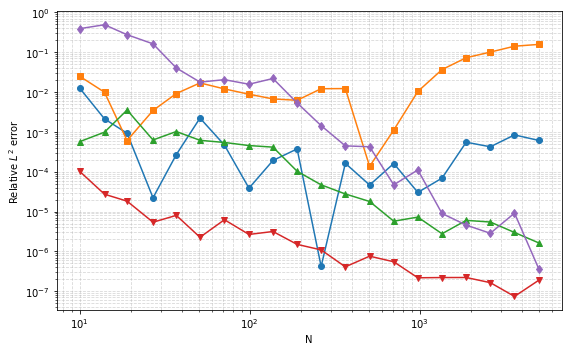

In [4]:

# 1) Combined Errors for all methods
plt.figure(figsize=(8, 5))
plt.loglog(n_arr, errors_es,     '-o', color=color_es,   label='ε-scaling')
plt.loglog(n_arr, errors_gh,     '-s', color=color_gh, label='Greenkhorn')
plt.loglog(n_arr, rel_errors_kNN, '-^', color=color_knn,  label='k-NN')
plt.loglog(n_arr, rel_errors_OLS, '-v', color=color_ols,    label='OLS')
plt.loglog(n_arr, rel_errors_NW, '-d', color=color_nw, label='NW')

plt.xlabel(f'N')
plt.ylabel('Relative $L^2$ error')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("EM_comp_sink_N_error.png", dpi=300)
plt.show()


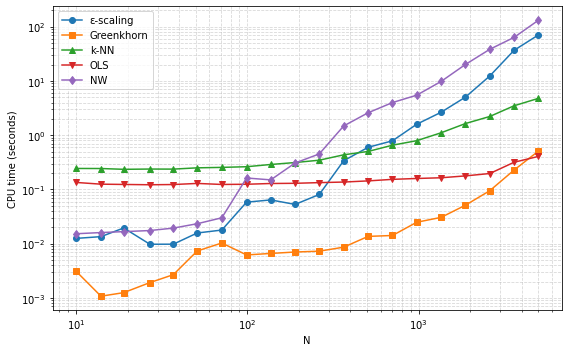

In [ ]:
plt.figure(figsize=(8, 5))
plt.loglog(n_arr, times_es,     '-o', color=color_es,   label='ε-scaling')
plt.loglog(n_arr, times_gh,     '-s', color=color_gh, label='Greenkhorn')
plt.loglog(n_arr, time_kNN, '-^', color=color_knn,  label='k-NN')
plt.loglog(n_arr, time_OLS, '-v', color=color_ols,    label='OLS')
plt.loglog(n_arr, time_NW, '-d', color=color_nw, label='NW')
plt.xlabel(f'N')
plt.ylabel('CPU time (seconds)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("EM_comp_sink_N_time.png", dpi=300)
plt.show()